# Supervised learning - classification of the pump sensor data

In [78]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

#### Check the raw data

In [79]:
df = pd.read_csv('data/pump_sensor.csv')
df

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.211800,46.310760,634.375000,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.211800,46.397570,638.888900,73.54598,13.32465,16.03733,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.168400,46.397568,628.125000,76.98898,13.31742,16.24711,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.211800,46.397568,636.458300,76.58897,13.35359,16.21094,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220315,220315,2018-08-31 23:55:00,2.407350,47.69965,50.520830,43.142361,634.722229,64.59095,15.11863,16.65220,...,38.28125,68.287030,52.37268,48.32176,41.087960,212.3843,153.64580,NaN,231.1921,NORMAL
220316,220316,2018-08-31 23:56:00,2.400463,47.69965,50.564240,43.142361,630.902771,65.83363,15.15480,16.70284,...,38.28125,66.840280,50.63657,48.03241,40.798610,213.8310,156.25000,NaN,231.1921,NORMAL
220317,220317,2018-08-31 23:57:00,2.396528,47.69965,50.520830,43.142361,625.925903,67.29445,15.08970,16.70284,...,39.06250,65.393520,48.90046,48.03241,40.798610,217.3032,155.38190,NaN,232.0602,NORMAL
220318,220318,2018-08-31 23:58:00,2.406366,47.69965,50.520832,43.142361,635.648100,65.09175,15.11863,16.56539,...,40.62500,64.236110,47.74306,48.32176,40.509258,222.5116,153.93520,NaN,234.0856,NORMAL


- Looks like we have a time series for 5 months measured every minute - too short time-frame to consider seasonality.
- Numerical data
- Categorical target variable
- Some missing values

#### Basic checks

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 55 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      220320 non-null  int64  
 1   timestamp       220320 non-null  object 
 2   sensor_00       210112 non-null  float64
 3   sensor_01       219951 non-null  float64
 4   sensor_02       220301 non-null  float64
 5   sensor_03       220301 non-null  float64
 6   sensor_04       220301 non-null  float64
 7   sensor_05       220301 non-null  float64
 8   sensor_06       215522 non-null  float64
 9   sensor_07       214869 non-null  float64
 10  sensor_08       215213 non-null  float64
 11  sensor_09       215725 non-null  float64
 12  sensor_10       220301 non-null  float64
 13  sensor_11       220301 non-null  float64
 14  sensor_12       220301 non-null  float64
 15  sensor_13       220301 non-null  float64
 16  sensor_14       220299 non-null  float64
 17  sensor_15 

- The data is mainly numerical, except the target variable with categorical values. <br>
- All data from Sensor 15 is missing - can be dropped. This sensor should be checked on-site immediately. <br>
- First column "Unnamed: 0" contains only the index - can be dropped, because it is redundant.

In [81]:
drop_cols = ['sensor_15', 'Unnamed: 0', 'timestamp']
df.drop(drop_cols, axis=1, inplace=True)

In [82]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
sensor_00,210112.0,2.372221,0.412227,0.000000,2.438831,2.456539,2.499826,2.549016
sensor_01,219951.0,47.591611,3.296666,0.000000,46.310760,48.133678,49.479160,56.727430
sensor_02,220301.0,50.867392,3.666820,33.159720,50.390620,51.649300,52.777770,56.032990
sensor_03,220301.0,43.752481,2.418887,31.640620,42.838539,44.227428,45.312500,48.220490
sensor_04,220301.0,590.673936,144.023912,2.798032,626.620400,632.638916,637.615723,800.000000
sensor_05,220301.0,73.396414,17.298247,0.000000,69.976260,75.576790,80.912150,99.999880
sensor_06,215522.0,13.501537,2.163736,0.014468,13.346350,13.642940,14.539930,22.251160
sensor_07,214869.0,15.843152,2.201155,0.000000,15.907120,16.167530,16.427950,23.596640
sensor_08,215213.0,15.200721,2.037390,0.028935,15.183740,15.494790,15.697340,24.348960
sensor_09,215725.0,14.799210,2.091963,0.000000,15.053530,15.082470,15.118630,25.000000


#### Missing data check

In [83]:
missing_dict = dict()

# summarize the number of rows with missing values for each column
for column in df.columns:
    # count number of rows with missing values
    n_miss = df[column].isnull().sum()
    perc = n_miss / df.shape[0] * 100
    # append to dict
    missing_dict[column] = [n_miss, perc.round(2)]

missing_df = pd.DataFrame(missing_dict.values(),
                          index=missing_dict.keys(),
                          columns=['N_Missing [-]', 'Percentage [%]'])
missing_df

,N_Missing [-],Percentage [%]
sensor_00,10208,4.63
sensor_01,369,0.17
sensor_02,19,0.01
sensor_03,19,0.01
sensor_04,19,0.01
sensor_05,19,0.01
sensor_06,4798,2.18
sensor_07,5451,2.47
sensor_08,5107,2.32
sensor_09,4595,2.09


#### Considered for dropping (>0.2% missing)

In [84]:
for key, value in missing_dict.items():
    if value[1] > 0.2:
        print(key, value[1])

sensor_00 4.63
sensor_06 2.18
sensor_07 2.47
sensor_08 2.32
sensor_09 2.09
sensor_50 34.96
sensor_51 6.98


Overall good availability of the data. With these percentages, missing values can be potentially imputed: <br>
- Sensor 50 can stay if there is value in it - e.g. strong corelation with the target variable. <br>
It could be dropped if there is a very strong correlation with other sensor(s) and similar information is available in the model. <br>
- Sensor 51 could be removed if correlation with target is weak. 

There are many types of interpolations available, e.g.: Linear, Spline, Stineman. <br>
KNN would be possible to use, but it is more applicable to static data, instead of time-series. <br>
Other, simple methods, like mean, median, mode, last/next value can be an over-simplification.

#### Recovery rows, broken states and missing values

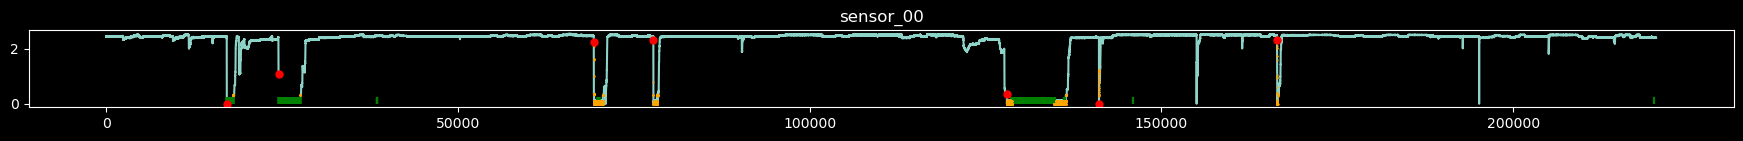

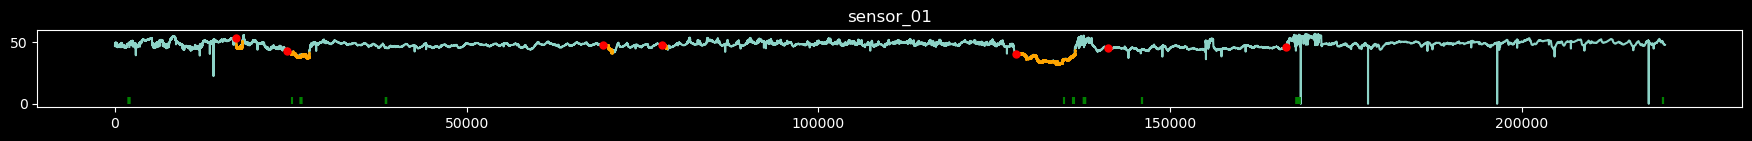

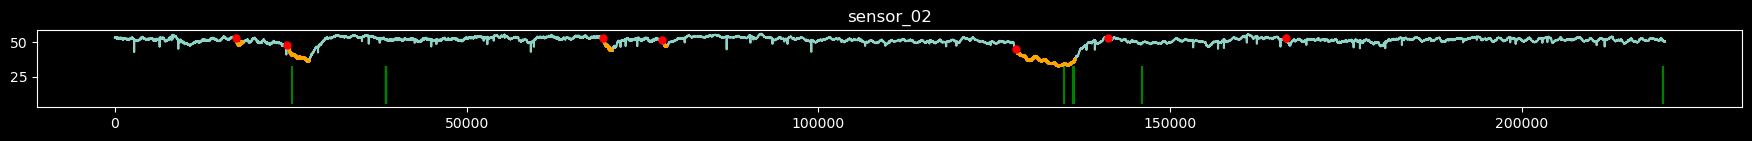

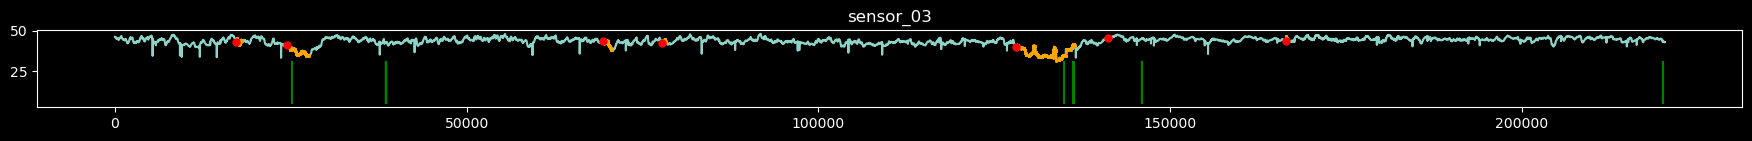

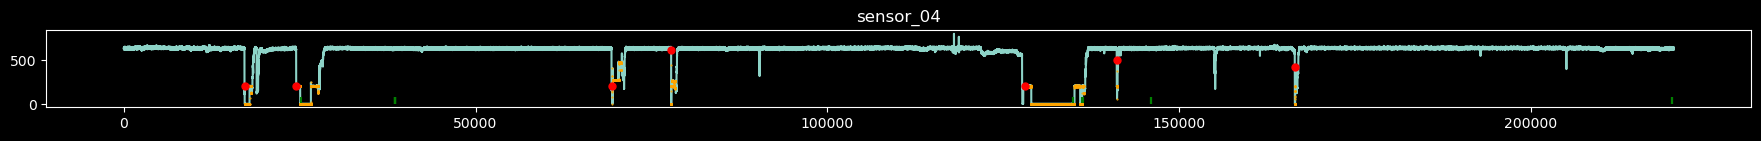

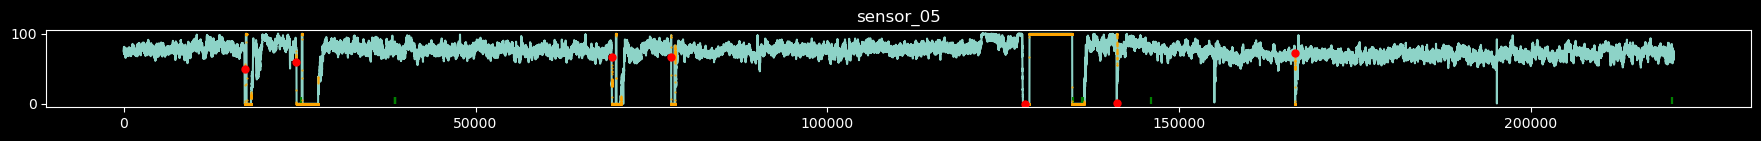

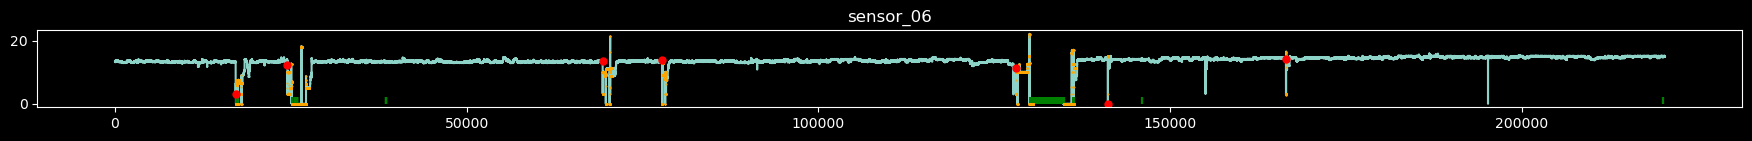

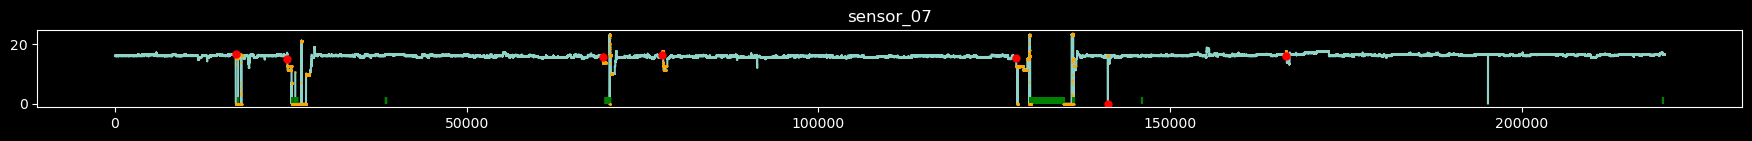

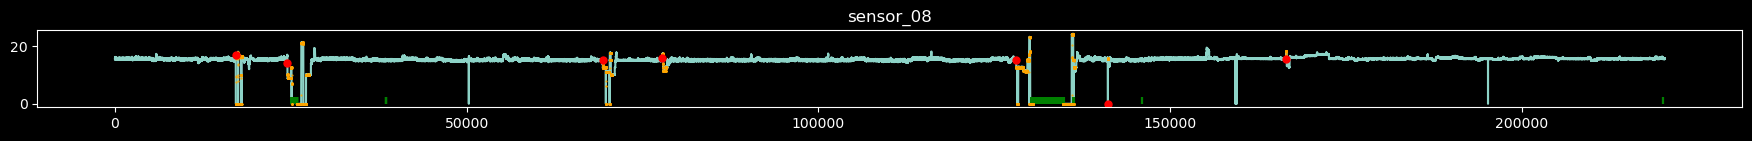

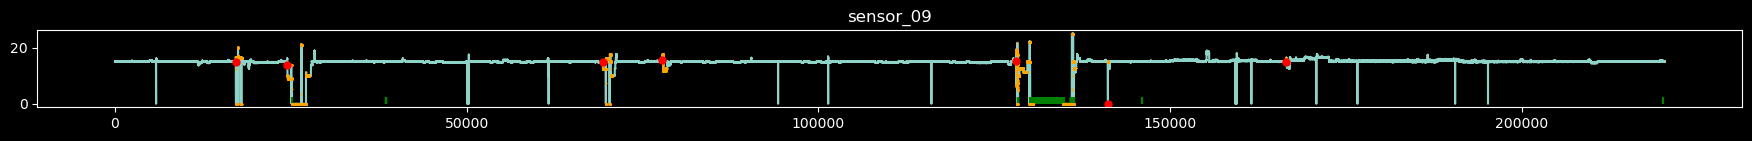

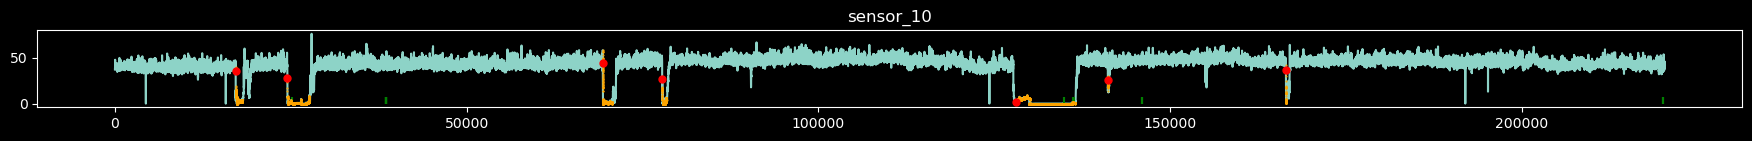

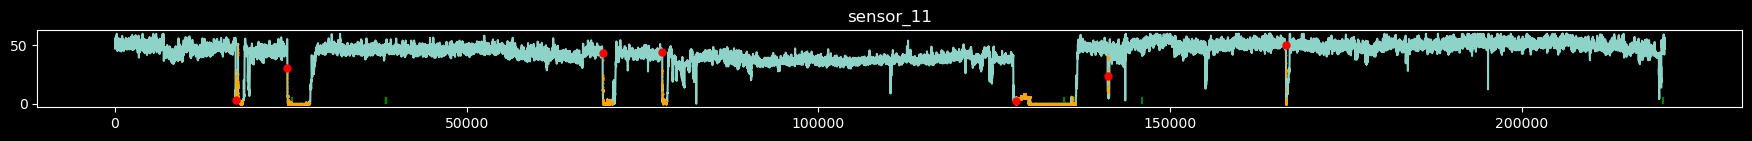

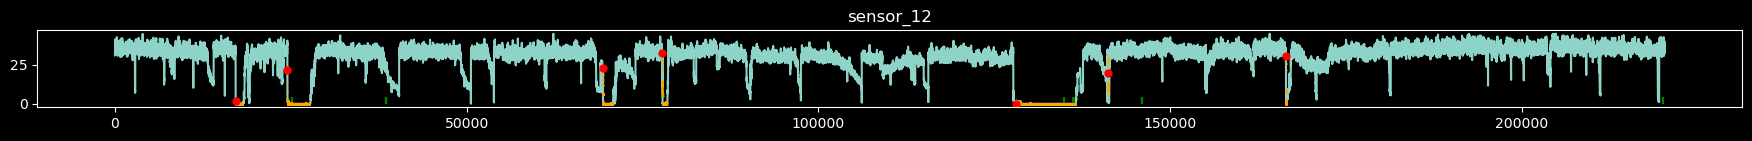

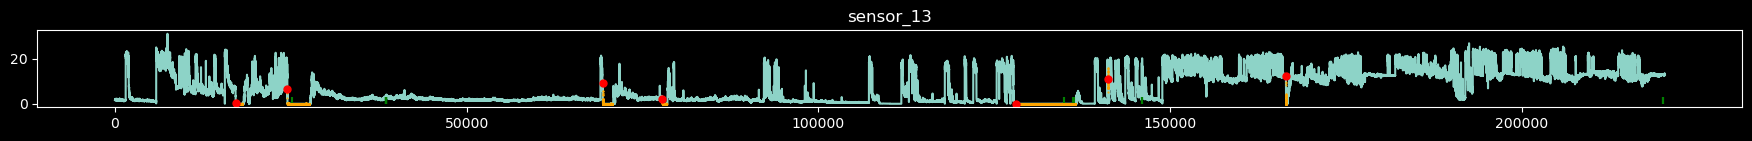

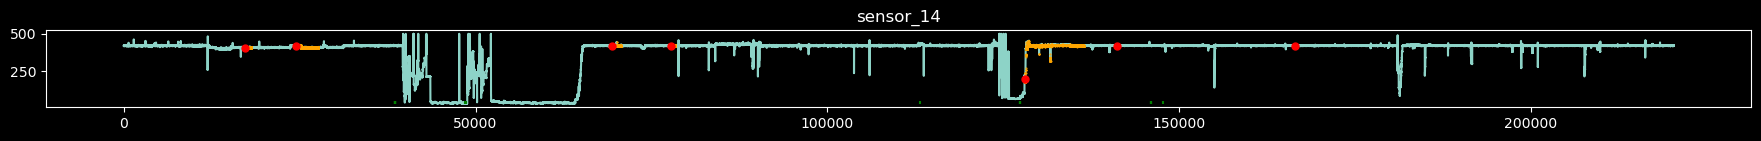

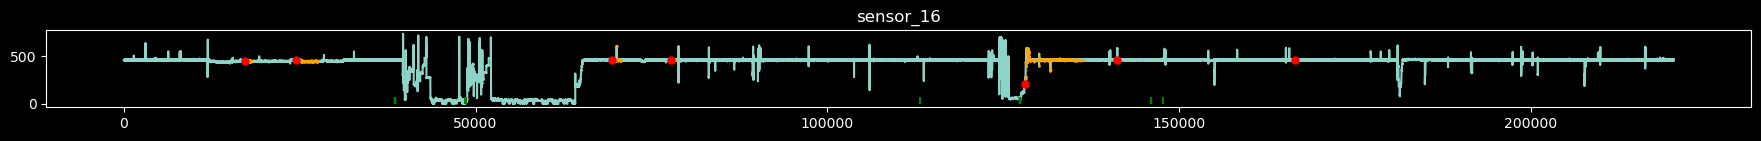

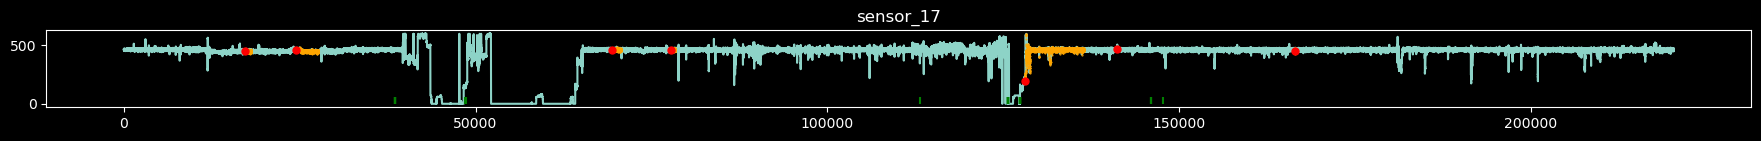

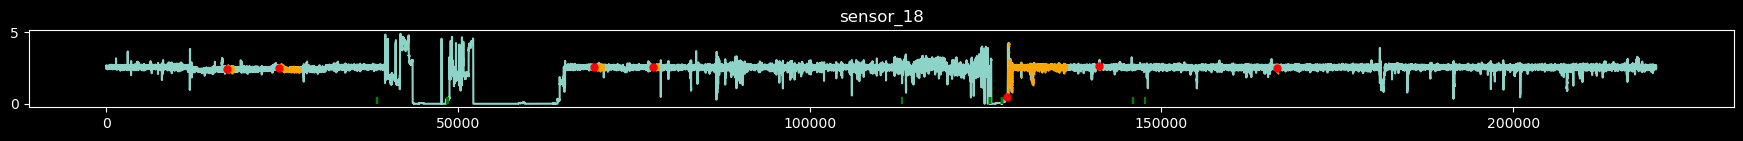

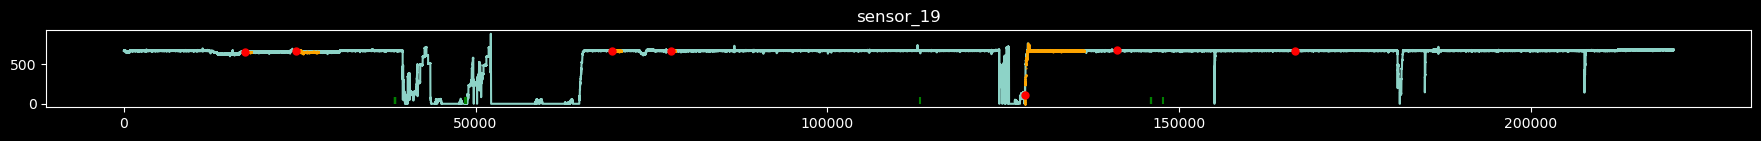

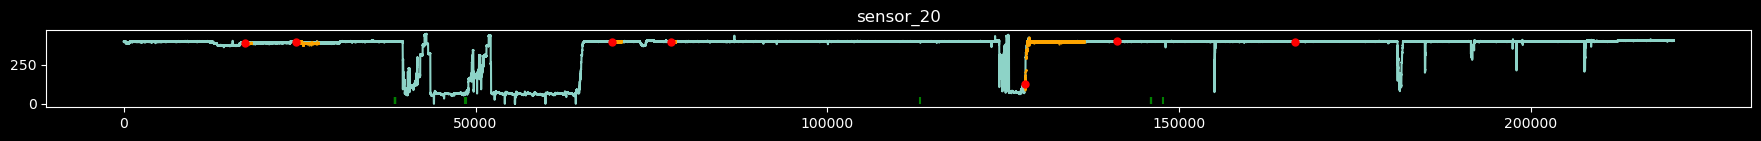

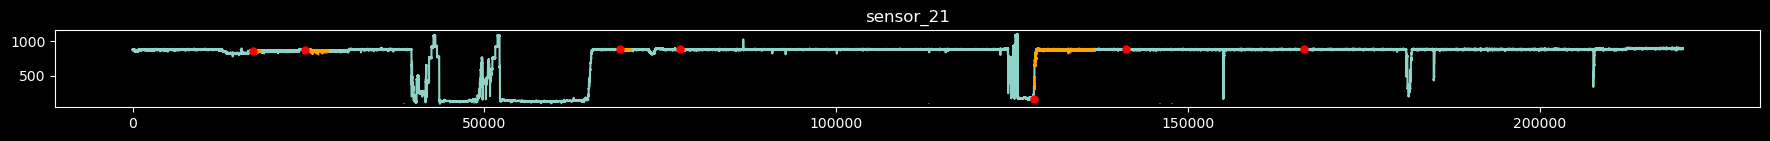

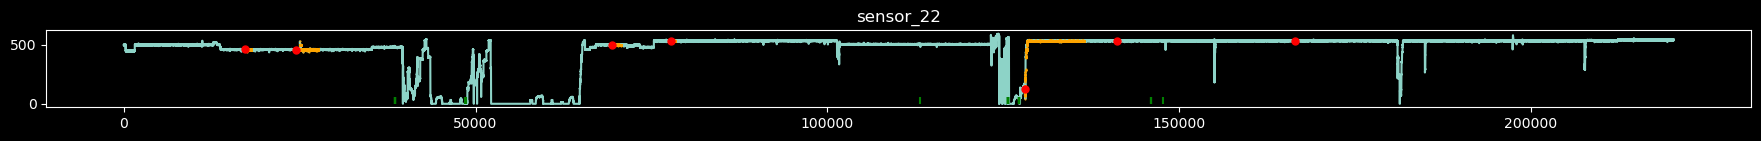

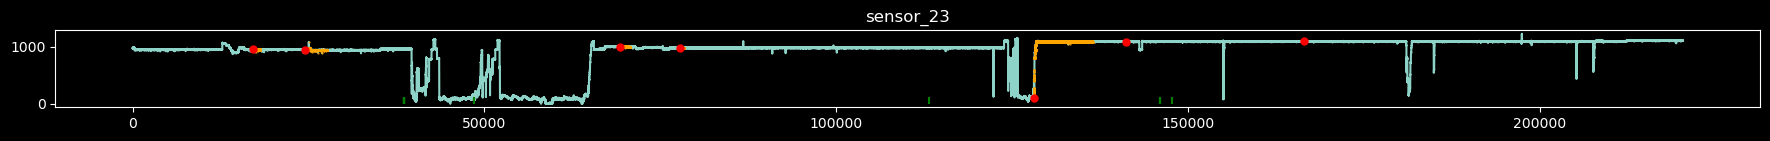

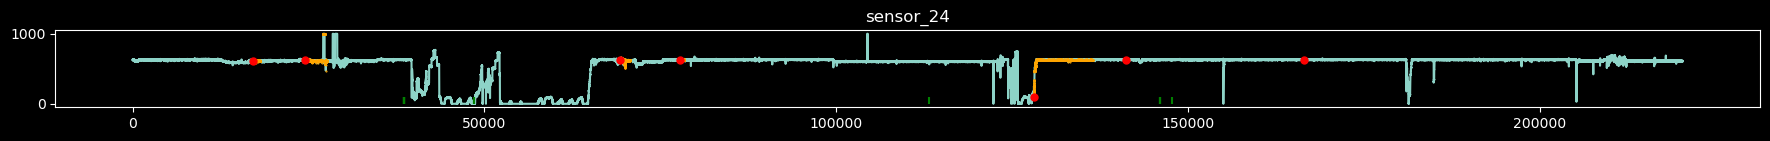

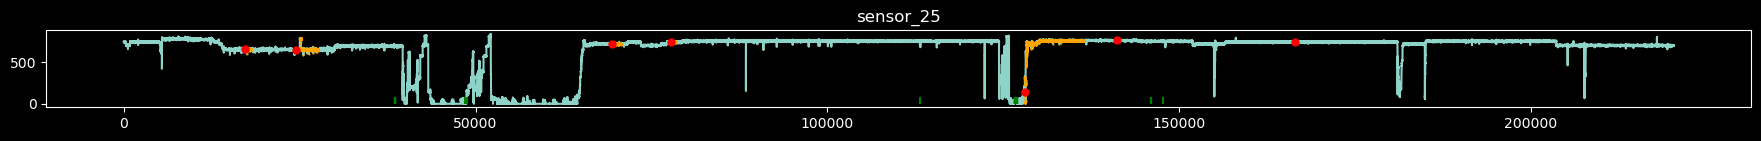

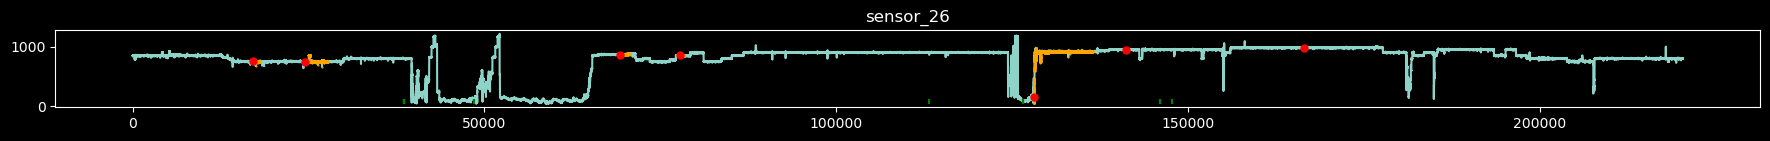

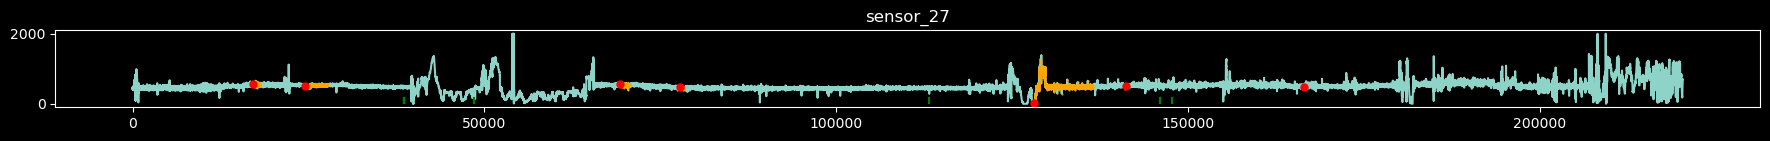

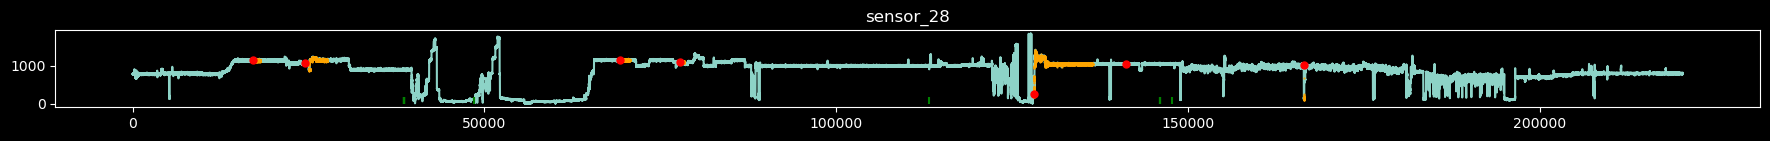

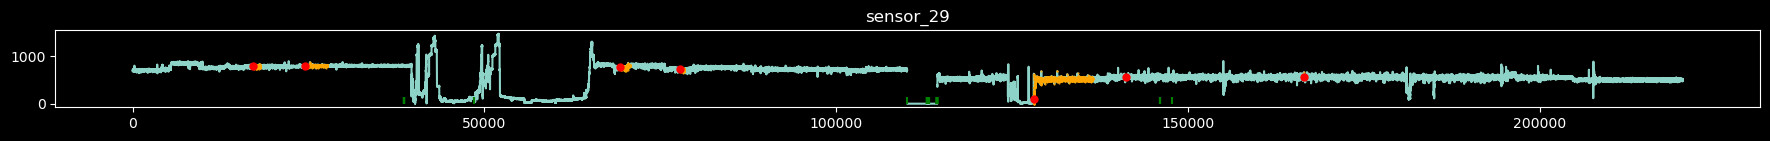

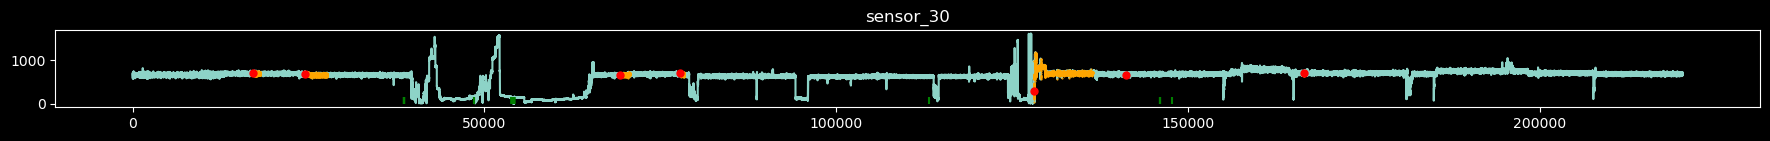

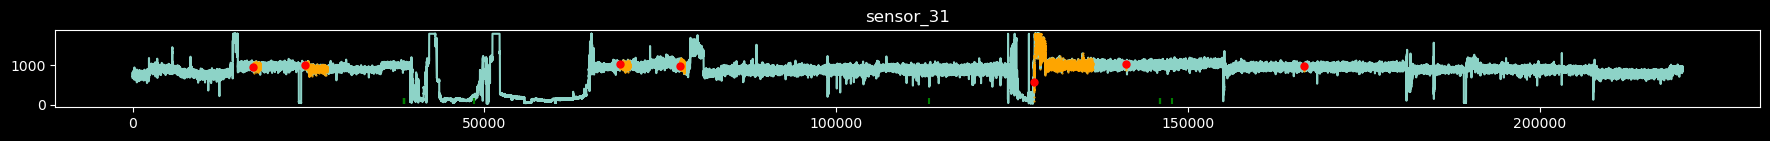

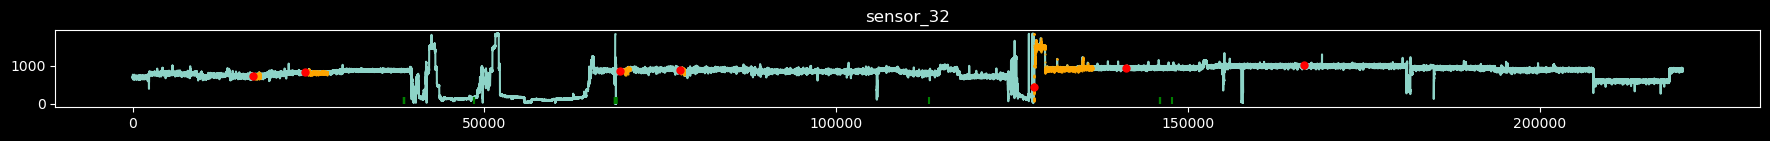

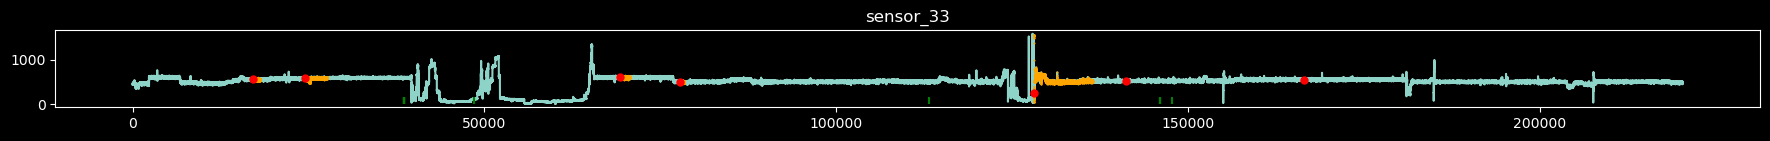

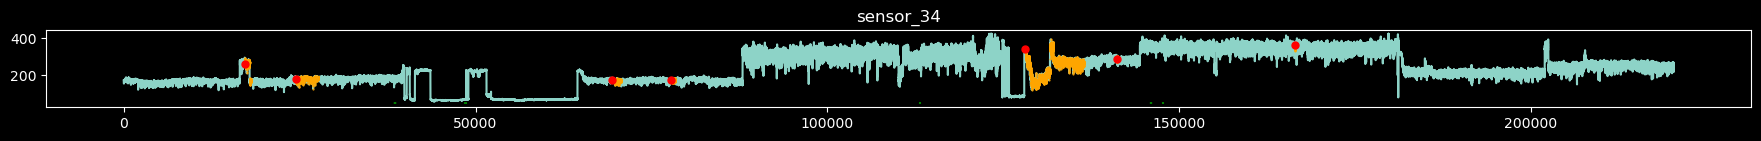

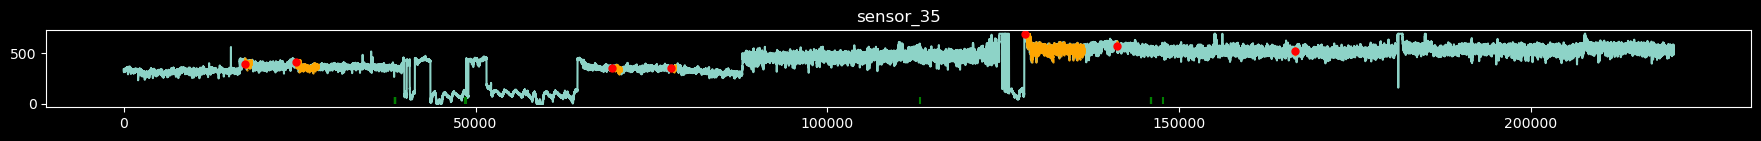

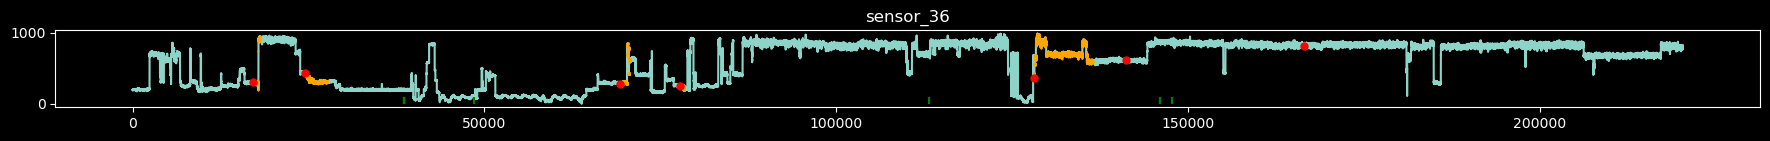

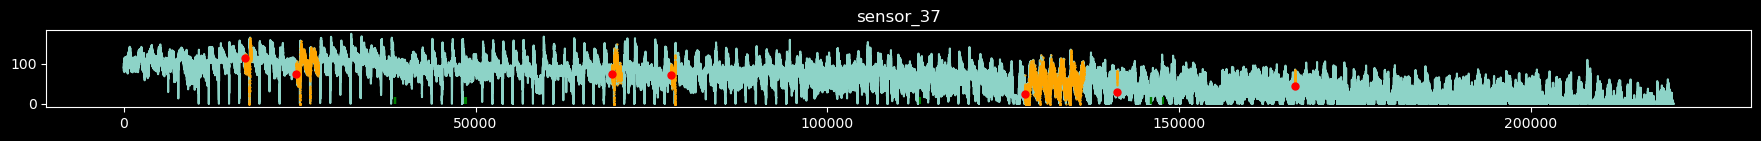

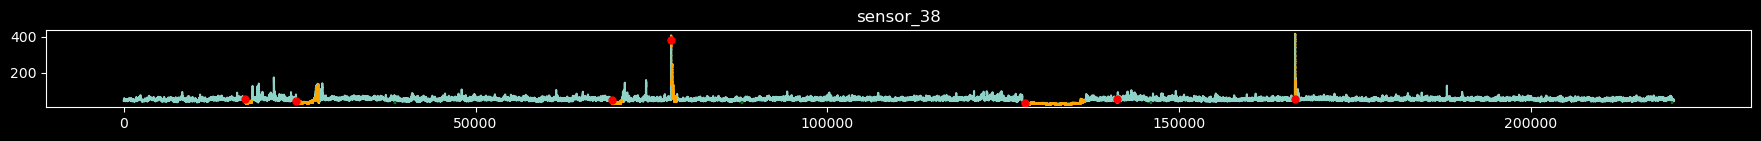

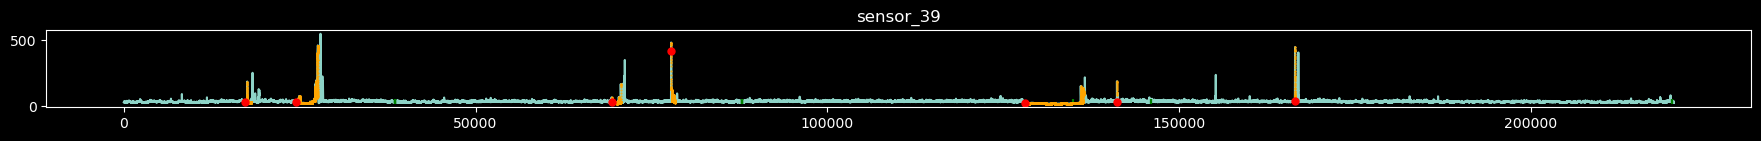

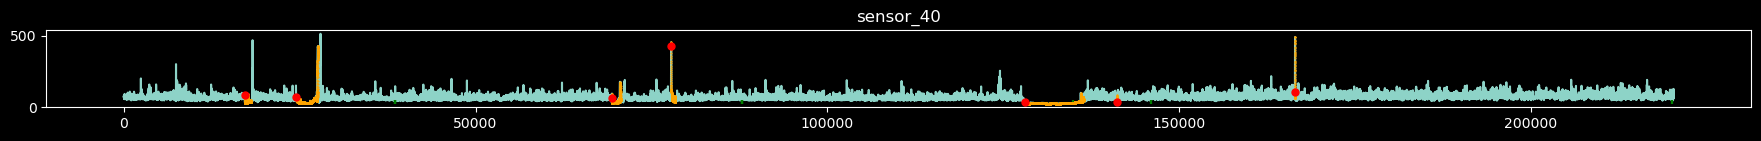

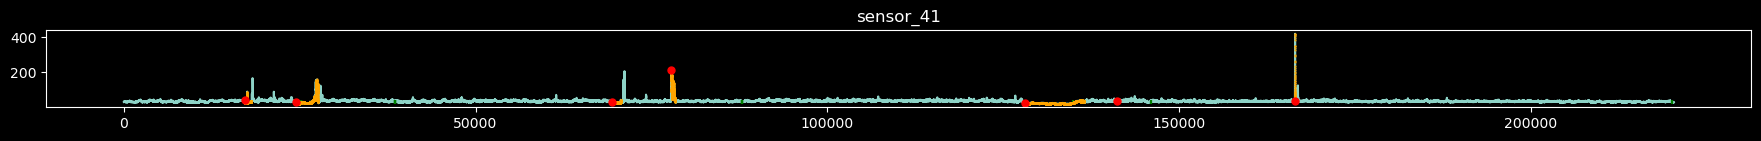

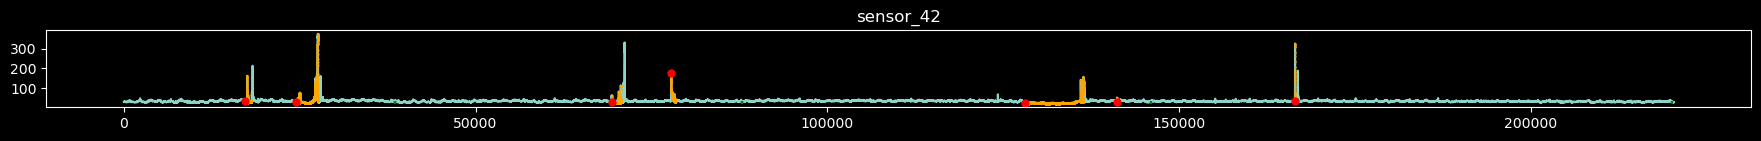

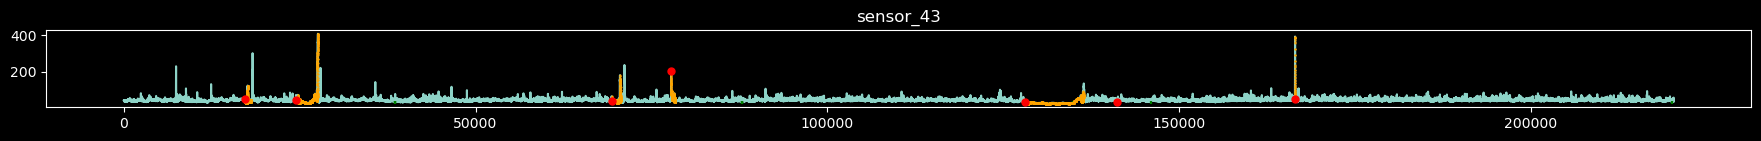

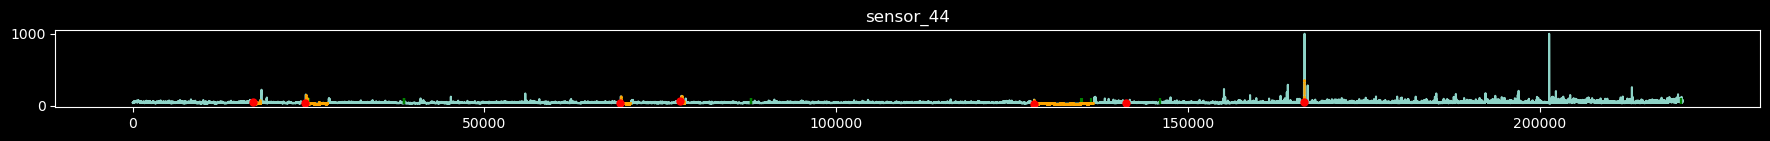

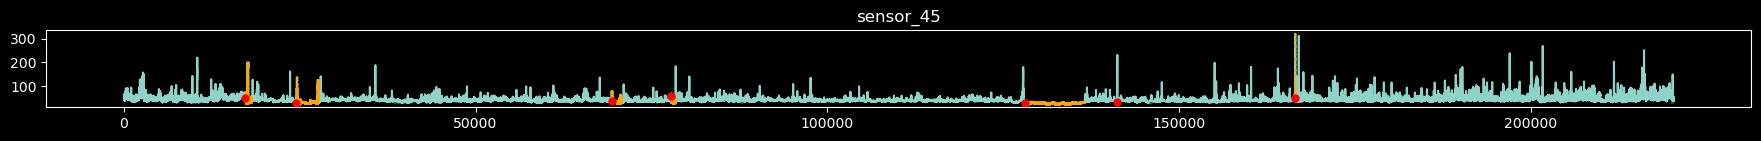

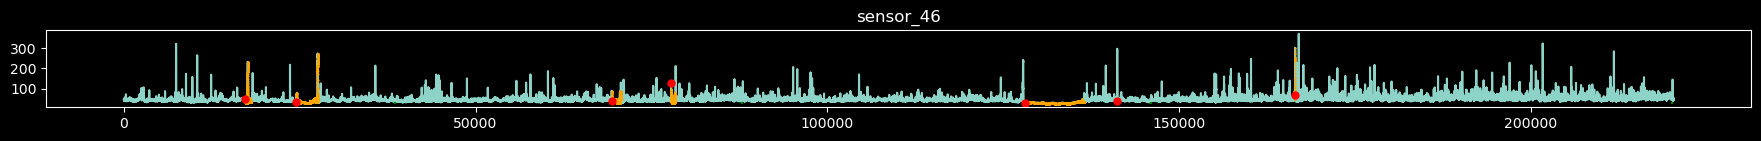

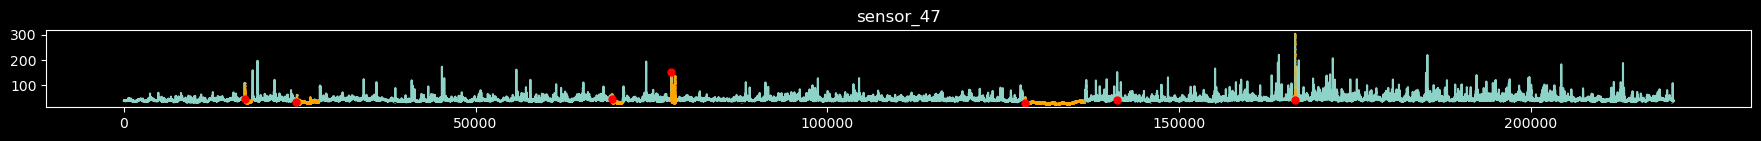

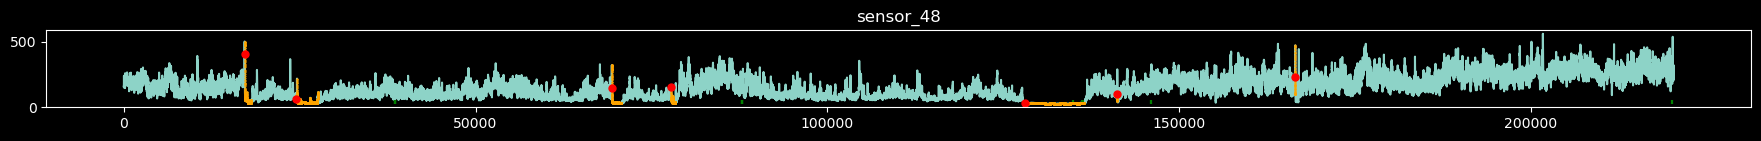

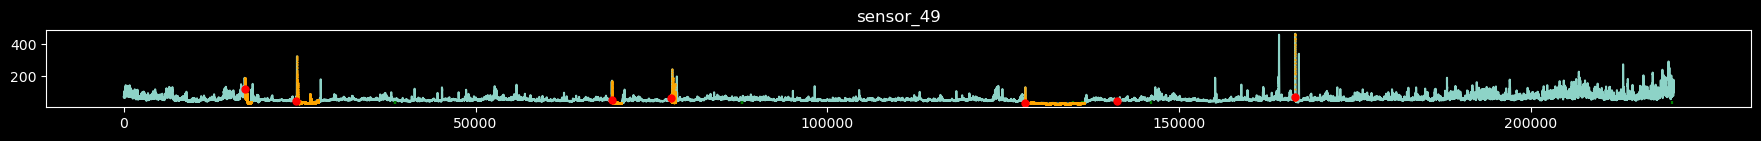

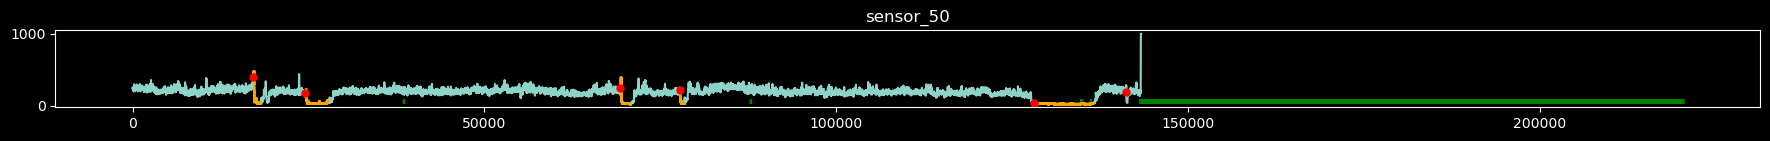

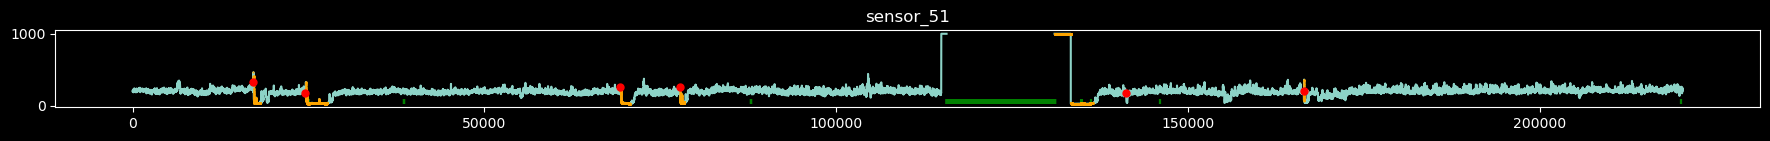

In [149]:
sensors = df.drop('machine_status', axis=1)

broken = df[df['machine_status']=='BROKEN']
recovery = df[df['machine_status']=='RECOVERING']
missing = df[df.isnull().any(axis=1)]

for sensor in sensors:
    plot = plt.figure(figsize=(22,1))
    
    plot = plt.plot(df[sensor])
    plot = plt.vlines(x=df[df[sensor].isnull()][sensor].index, ymin=min(df[sensor]), ymax=max(df[sensor])/10, colors='green')
    plot = plt.plot(recovery[sensor], linestyle='none', marker='.', color='orange', markersize=1)
    plot = plt.plot(broken[sensor], linestyle='none', marker='o', color='red', markersize=5)
    
    plot = plt.title(sensor)
    plt.show();

#### Check skeweness of target class

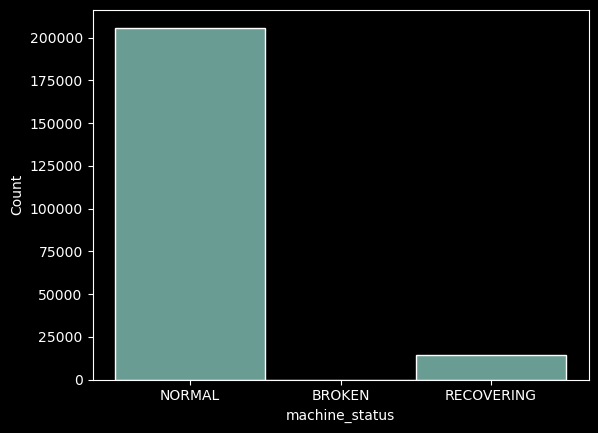

In [9]:
plt.style.use("dark_background")
sns.histplot(df.machine_status);

Big skeweness in the target variable may result in a model biased towards one of the classes.<br>
Conversion to numercial values needs to be done anyway. <br>
Potentially, classes could be: 0, 1, 2, but since recovering means the machine is still not normal, we can assign only two classes (0 and 1).

In [10]:
# replacing values
df['machine_status'].replace(['NORMAL', 'RECOVERING', 'BROKEN'], [1, 0, 0], inplace=True)

df.machine_status.value_counts()

1    205836
0     14484
Name: machine_status, dtype: int64

#### Target class as a time-series - when anomaly occurs:

<AxesSubplot: >

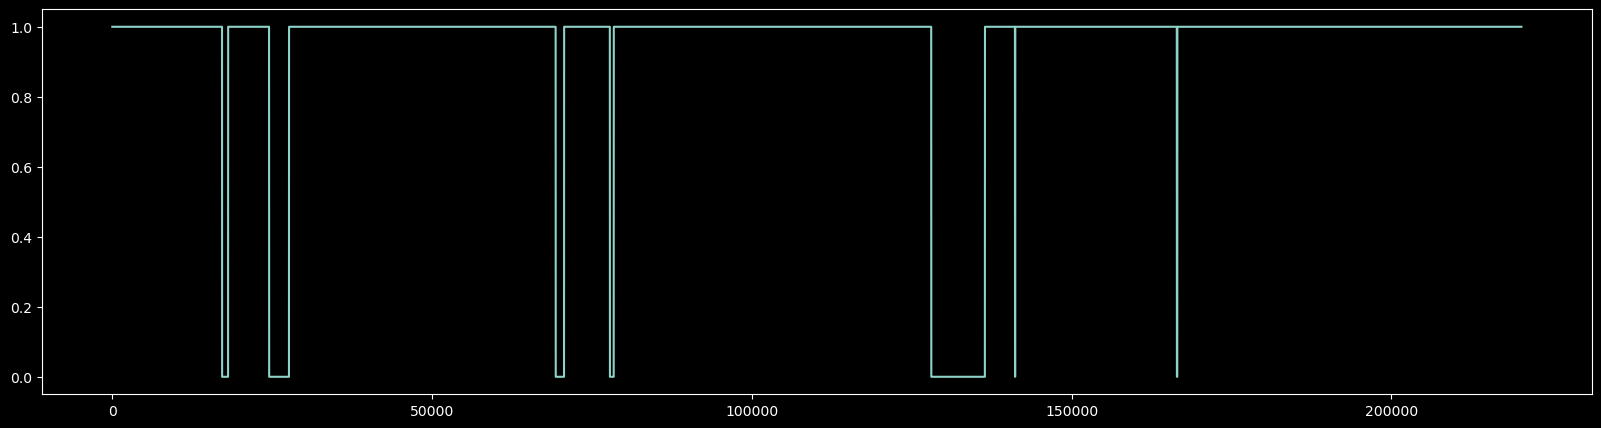

In [11]:
plt.figure(figsize=(20, 5))
df.machine_status.plot()

#### Check for outliers

In [12]:
Q1 = df.quantile(0.25) # lower percentile
Q3 = df.quantile(0.75) # upper percentile

# Inter-Quartile Range
IQR = Q3 - Q1

# Any data point less than the Lower Bound or more than the Upper Bound is considered as an outlier
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

is_outlier = ((df < lower_bound) | (df > upper_bound))

outlier_percentage = round(is_outlier.sum()/is_outlier.shape[0], 2)*100
outlier_df = pd.DataFrame(outlier_percentage, columns=['Outlier %'])
outlier_df

,Outlier %
sensor_00,9.0
sensor_01,6.0
sensor_02,7.0
sensor_03,5.0
sensor_04,12.0
sensor_05,9.0
sensor_06,5.0
sensor_07,6.0
sensor_08,7.0
sensor_09,31.0


#### Lower and upper bounds for outliers

In [13]:
pd.concat([lower_bound, upper_bound], axis=1, keys=['Lower Bound','Upper Bound'])

,Lower Bound,Upper Bound
sensor_00,2.347338,2.591319
sensor_01,41.558160,54.231760
sensor_02,46.809895,56.358495
sensor_03,39.127598,49.023441
sensor_04,610.127416,654.108707
sensor_05,53.572425,97.315985
sensor_06,11.555980,16.330300
sensor_07,15.125875,17.209195
sensor_08,14.413340,16.467740
sensor_09,14.955880,15.216280


In [14]:
df_no_outliers = df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]
df_no_outliers

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
9,2.445718,47.178820,53.16840,46.397568,641.7823,74.57428,13.38252,16.24711,15.61777,15.11863,...,41.66666,39.062500,56.42361,50.63657,39.06250,186.6319,69.73380,246.5278,200.8102,1
10,2.464410,47.482640,53.12500,46.397568,637.7314,76.05148,13.41146,16.16753,15.65393,15.11863,...,41.40625,39.351850,54.97685,50.92593,39.35185,190.9722,71.18056,250.8681,199.9421,1
11,2.444734,47.916660,53.16840,46.397568,635.6482,74.58654,13.41146,16.16753,15.84925,15.11863,...,41.66666,39.351852,53.81944,51.21528,39.06250,193.5764,72.33796,253.1829,200.2315,1
12,2.460474,48.263890,53.12500,46.397568,630.0926,76.95988,13.34635,16.16753,15.73351,15.01013,...,42.70833,39.351850,53.24074,50.92593,39.06250,195.6019,72.33796,253.1829,202.2569,1
13,2.448669,48.437500,53.16840,46.397568,638.6574,75.67310,13.31742,16.16753,15.84925,15.16927,...,42.70833,40.509260,53.81944,50.63657,39.06250,196.4699,72.91666,252.8935,202.8356,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212196,2.407350,50.824650,52.12674,46.180550,622.8009,66.77495,15.15480,16.70284,15.76968,15.08247,...,46.09375,42.534720,46.00694,48.90046,43.69213,162.0370,51.21528,NaN,232.9282,1
212197,2.402431,50.824650,52.08333,46.180553,637.1528,65.63858,15.04630,16.65220,15.65393,15.11863,...,47.91666,42.245370,46.58565,48.03241,42.53472,162.0370,52.08333,NaN,231.4815,1
212242,2.407350,51.041664,52.25694,46.093750,634.2593,70.83183,15.11863,16.75347,15.53096,15.11863,...,38.28125,44.560180,56.71296,43.11343,40.50926,250.8681,67.70834,NaN,214.1204,1
212243,2.399479,51.041664,52.30035,46.093750,633.1018,69.81438,15.08970,16.75347,15.56713,15.11863,...,38.80208,44.849540,55.26620,43.98148,39.64120,247.9745,66.55093,NaN,211.8056,1


Not too many rows in this case.

# Exploratory Data Analysis (EDA)

#### Correlation (Pearson's R)

<AxesSubplot: >

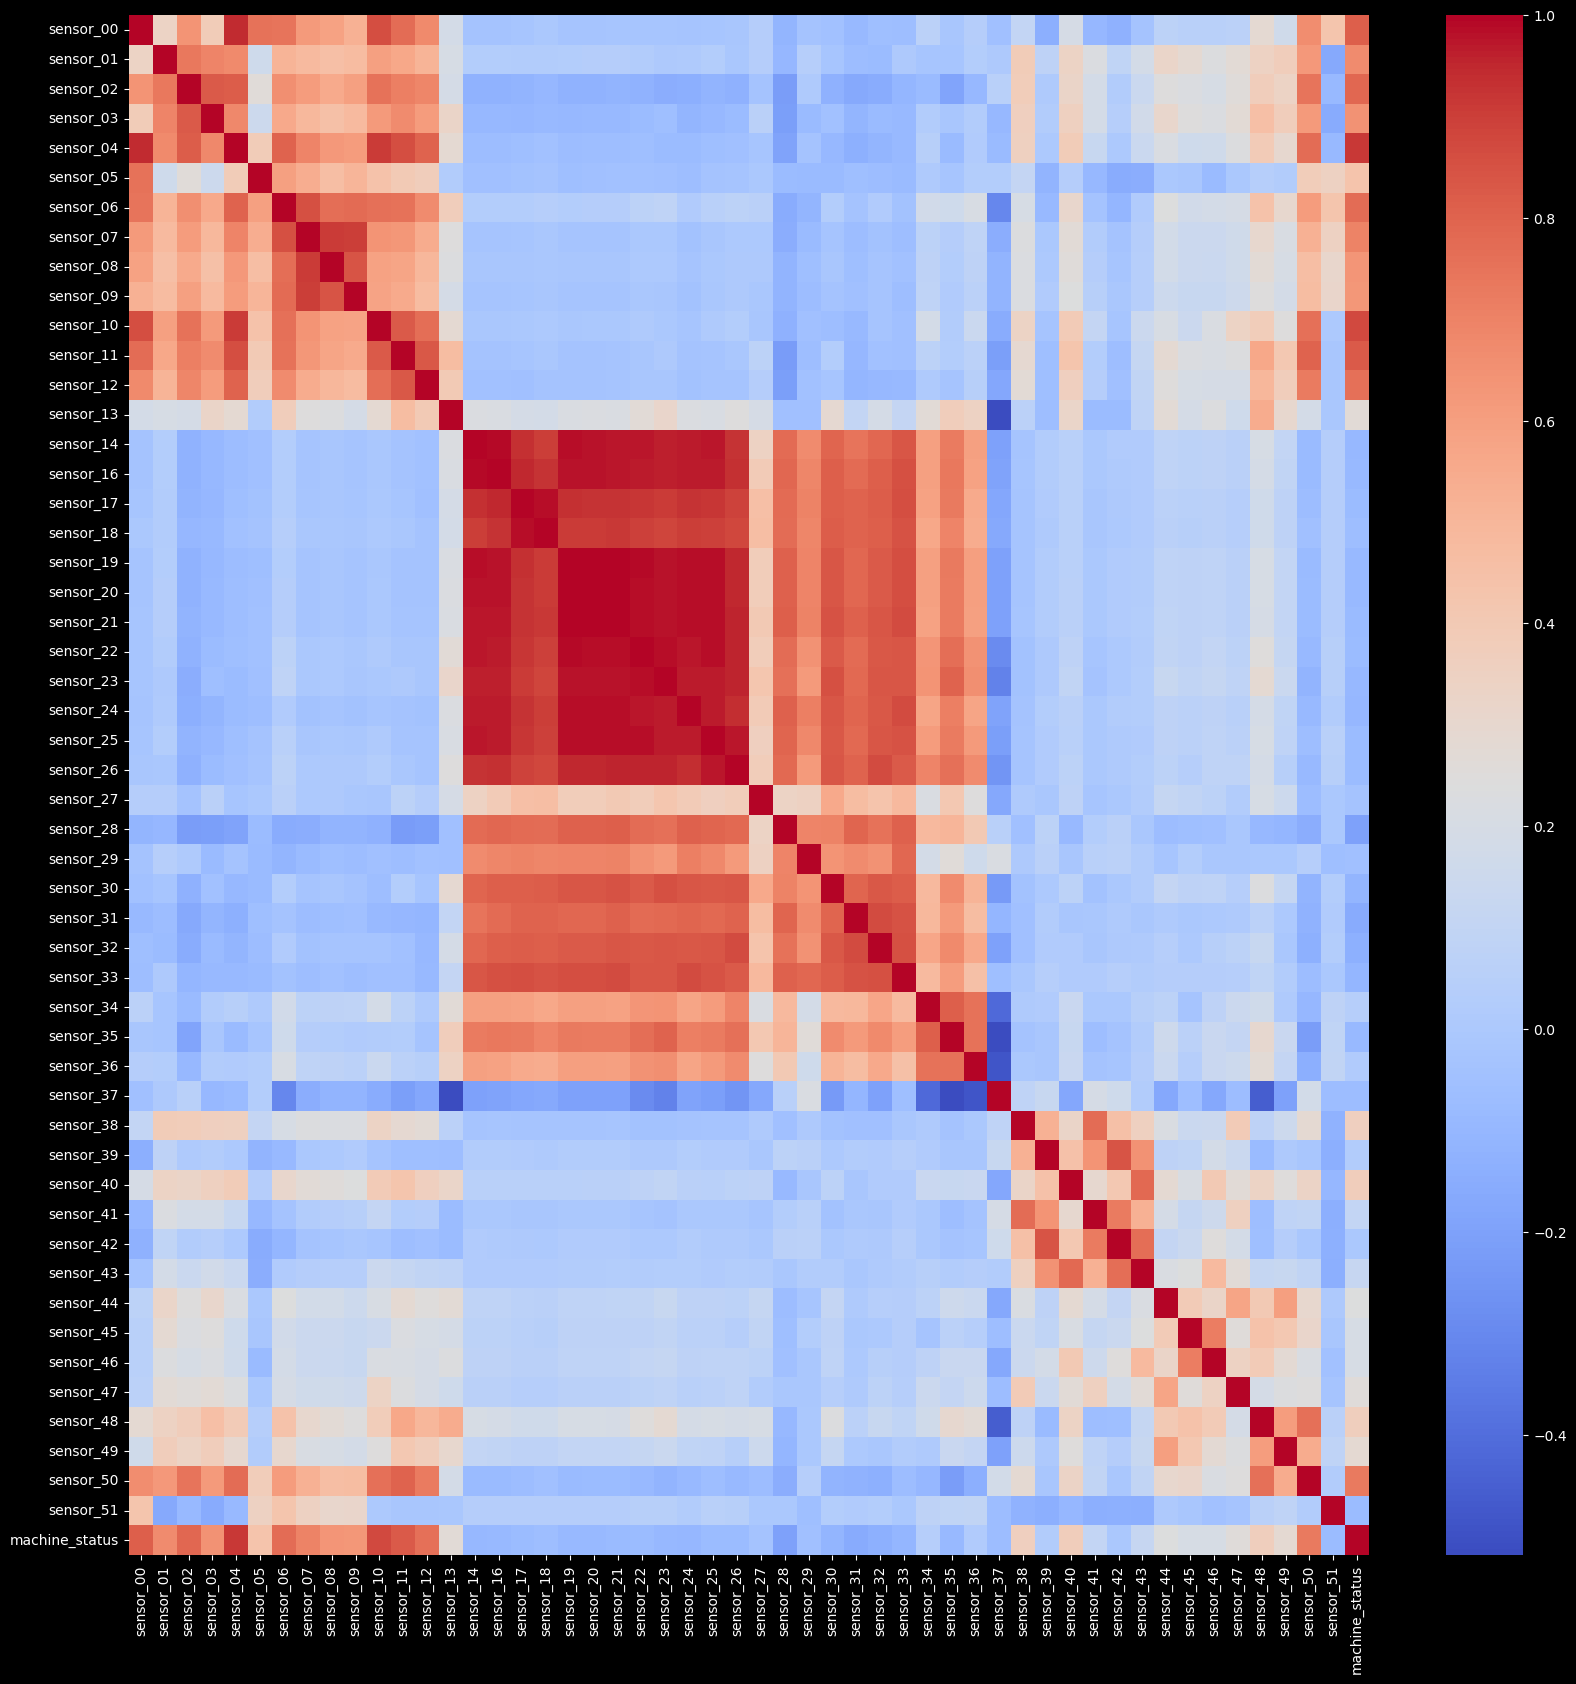

In [15]:
plt.figure(figsize=(20, 20))
sns.heatmap(df.corr(), cmap='coolwarm')

#### Occam's razor - the principle of parsimony - "the simpler the model, the better"
Some features (e.g. sensors 14-26) are strongly correlated. This increases model complexity and variance.<br>
Some columns (maybe from sensors 15-26) could be removed (this should be investigated).

<AxesSubplot: >

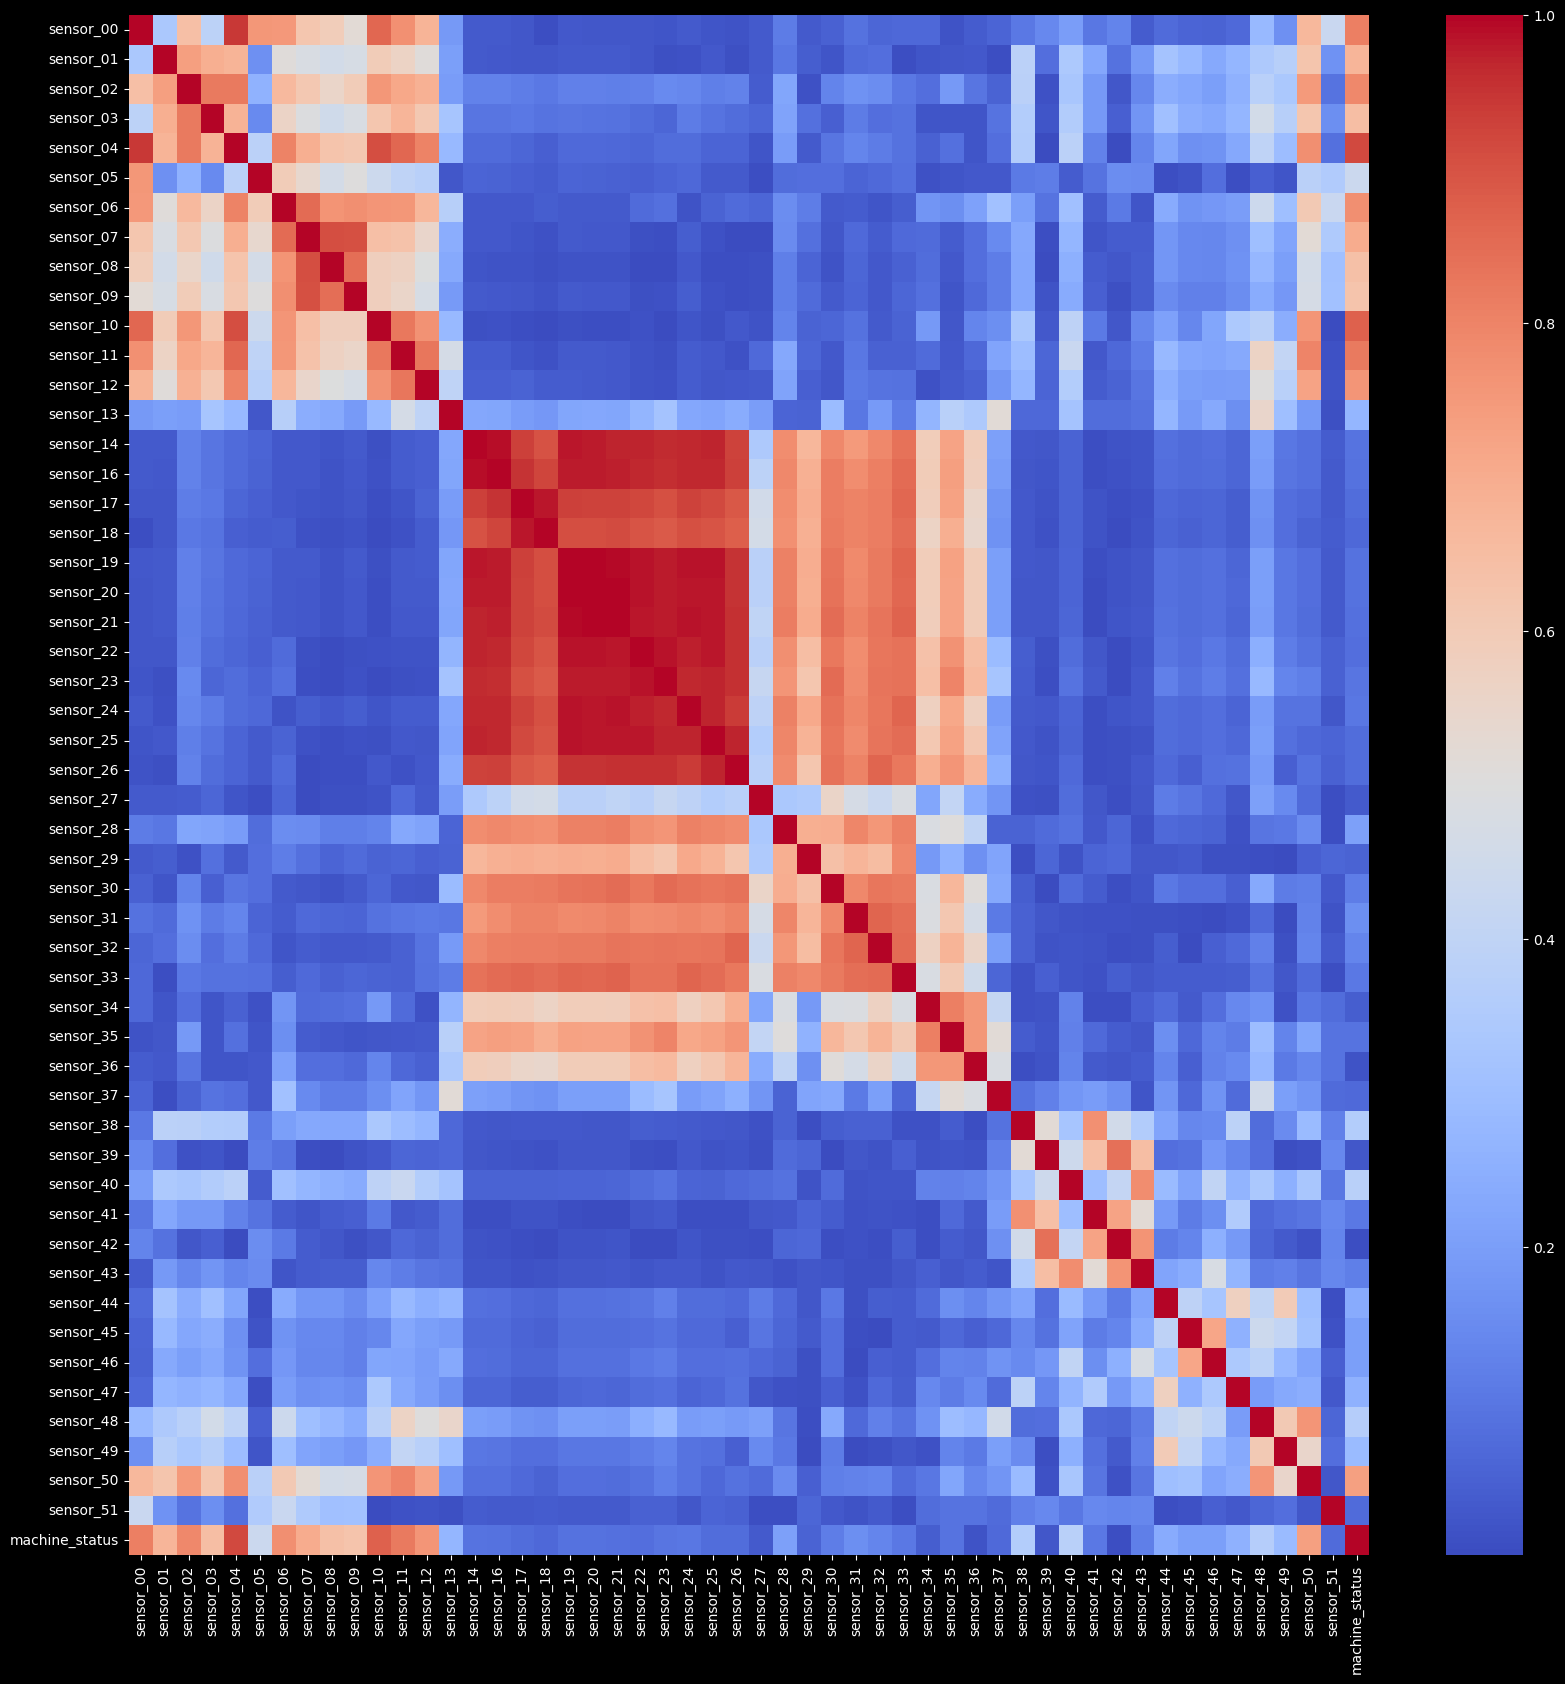

In [16]:
# Create correlation matrix
corr_matrix = df.corr().abs()
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, cmap='coolwarm')

#### Features to drop 
Due to high correlation with other variables (redundancy).

We can consider the columns of data representing dimensions on an n-dimensional feature space and the rows of data as points in that space. <br>
This is a useful geometric interpretation of a dataset.<br>

Having a large number of dimensions in the feature space can mean that the volume of that space is very large, and in turn, the points that we have in that space (rows of data) often represent a small and non-representative sample. <br>

This can dramatically impact the performance of machine learning algorithms fit on data with many input features, generally referred to as the “curse of dimensionality.” <br>

Therefore, it is often desirable to reduce the number of input features.

In [17]:
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
df.drop(to_drop, axis=1, inplace=True)

print('Dropped: ')
to_drop

Dropped: 


['sensor_16',
 'sensor_17',
 'sensor_18',
 'sensor_19',
 'sensor_20',
 'sensor_21',
 'sensor_22',
 'sensor_23',
 'sensor_24',
 'sensor_25',
 'sensor_26']

#### Time-series plot

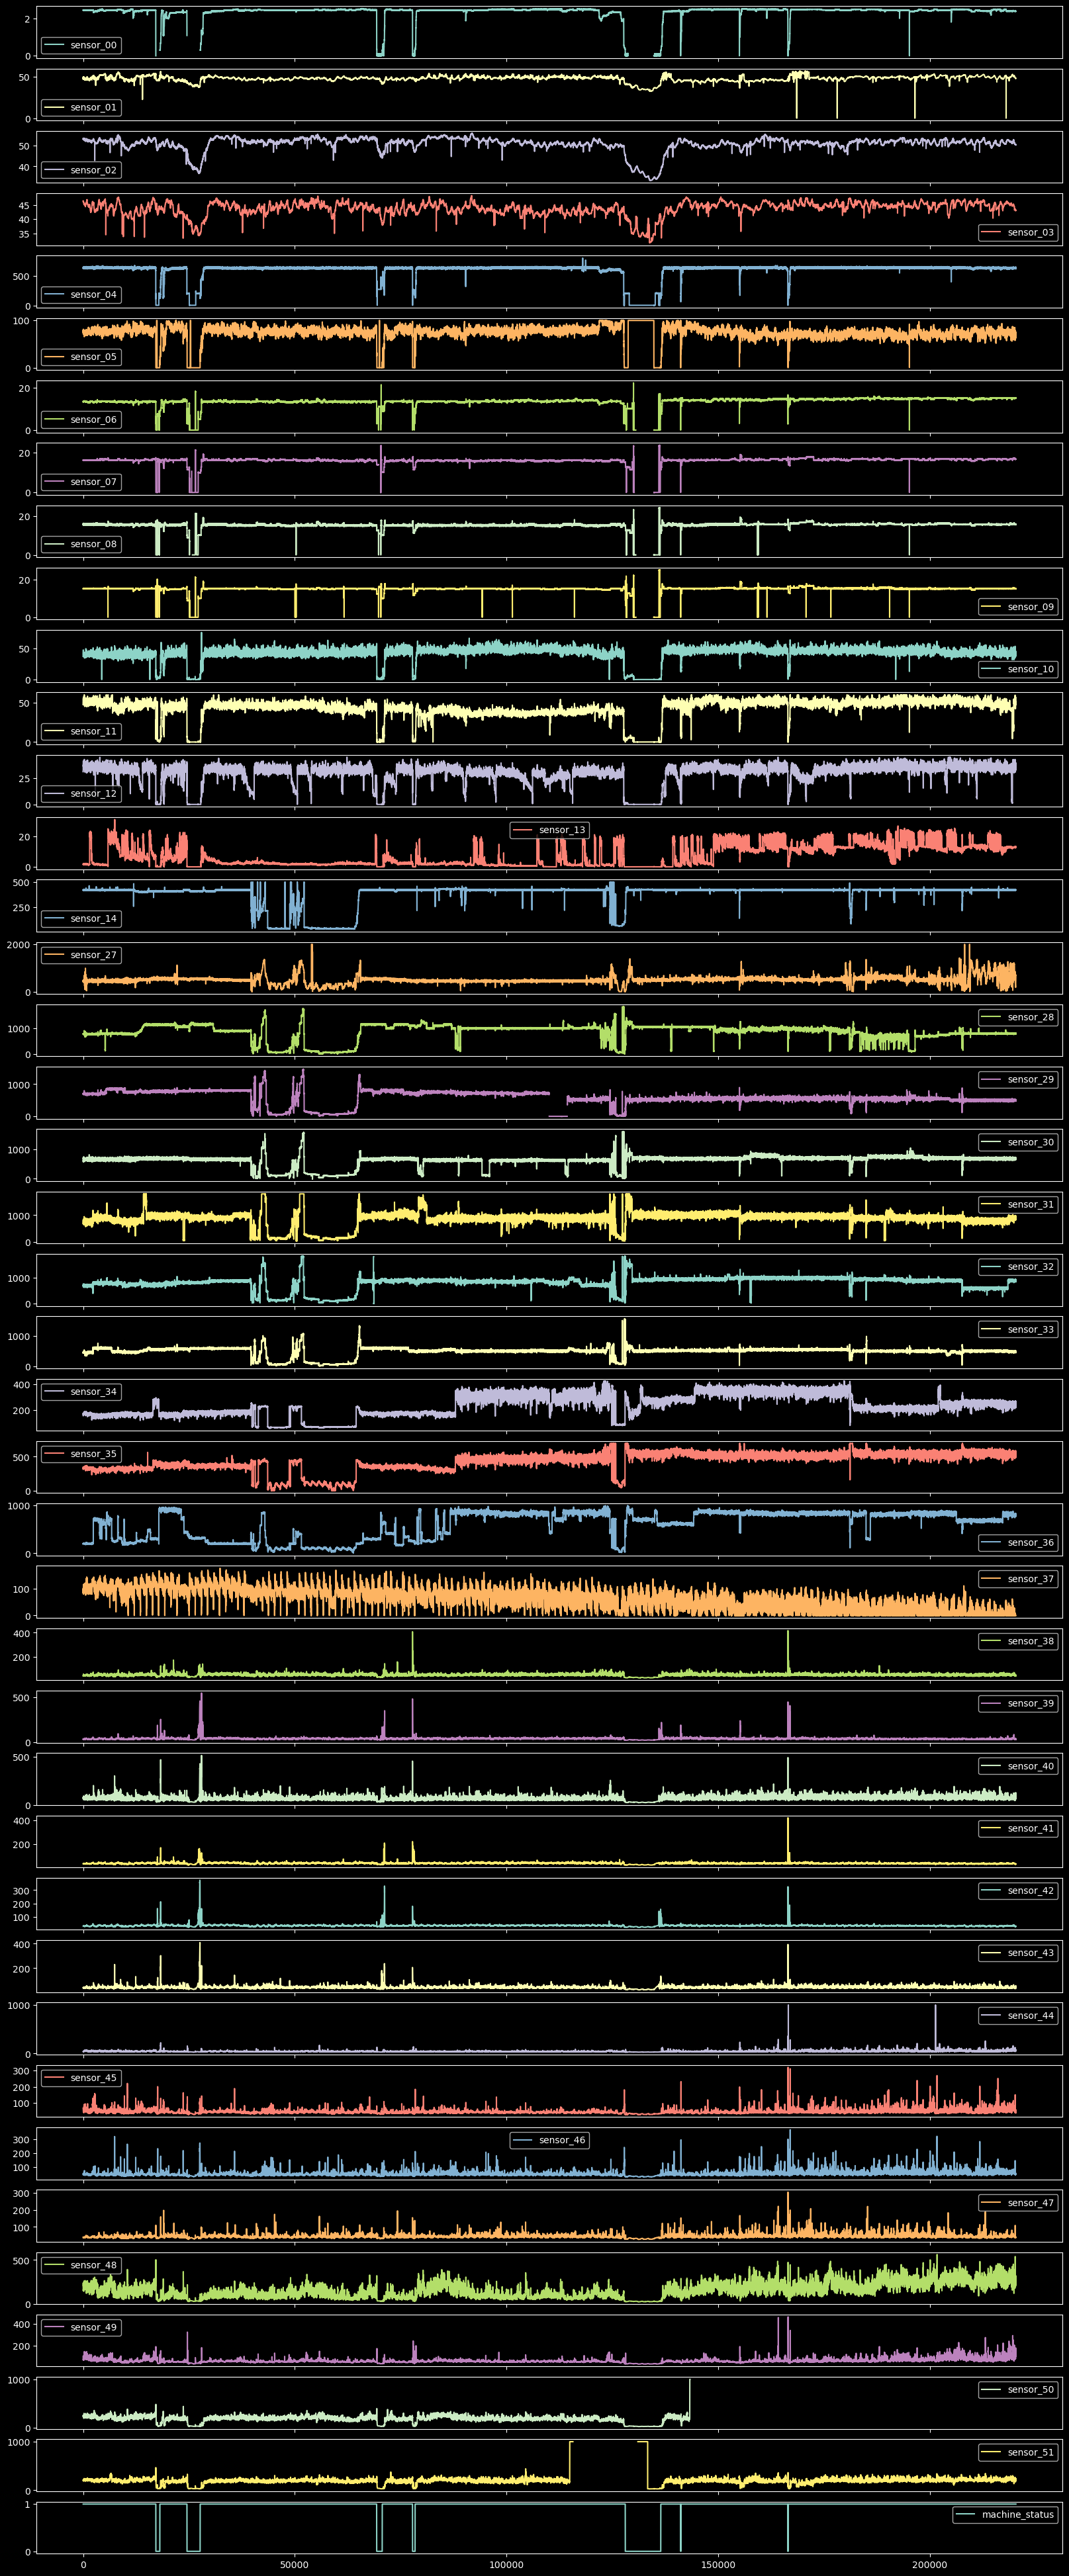

In [18]:
df.plot(subplots =True, sharex = True, figsize = (20,50));

Sensor 51 is poorly correlated - can be dropped

In [19]:
df.drop('sensor_51', axis=1, inplace=True)

#### Find strongly correlated patterns

#### Type 1

In [20]:
correlation = df.corr()['sensor_00'].sort_values(ascending=False)
correlation.head(6)

sensor_00         1.000000
sensor_04         0.942803
sensor_10         0.861392
machine_status    0.810822
sensor_11         0.770751
sensor_05         0.756697
Name: sensor_00, dtype: float64

In [22]:
# df1 = pd.DataFrame(data, columns=['Operation','sensor_01', 'sensor_04', 'sensor_10', 'sensor_14', 'sensor_19', 'sensor_25'])
# df0.plot(subplots =True, sharex = True, figsize = (20,20))

#### Type 2

In [23]:
correlation = df.corr()['sensor_14'].sort_values(ascending=False)
correlation.head(6)

sensor_14    1.000000
sensor_33    0.838371
sensor_30    0.792850
sensor_32    0.791290
sensor_28    0.778832
sensor_31    0.748317
Name: sensor_14, dtype: float64

#### Type 3

In [24]:
correlation = df.corr()['sensor_38'].sort_values(ascending=False)
correlation.head(6)

sensor_38    1.000000
sensor_41    0.771464
sensor_39    0.520642
sensor_42    0.454038
sensor_47    0.390392
sensor_01    0.384276
Name: sensor_38, dtype: float64

#### Visualizing missing values

In [25]:
# sensor_00 4.63
# sensor_06 2.18 
# sensor_07 2.47 
# sensor_08 2.32
# sensor_09 2.09 
# sensor_50 34.96
# sensor_51 6.98

In [26]:
missing = df[df['sensor_00'].isnull()].index.tolist()
df.iloc[missing,:]['sensor_00']

17160    NaN
17161    NaN
17162    NaN
17163    NaN
17164    NaN
          ..
145993   NaN
145994   NaN
220008   NaN
220009   NaN
220010   NaN
Name: sensor_00, Length: 10208, dtype: float64

<AxesSubplot: >

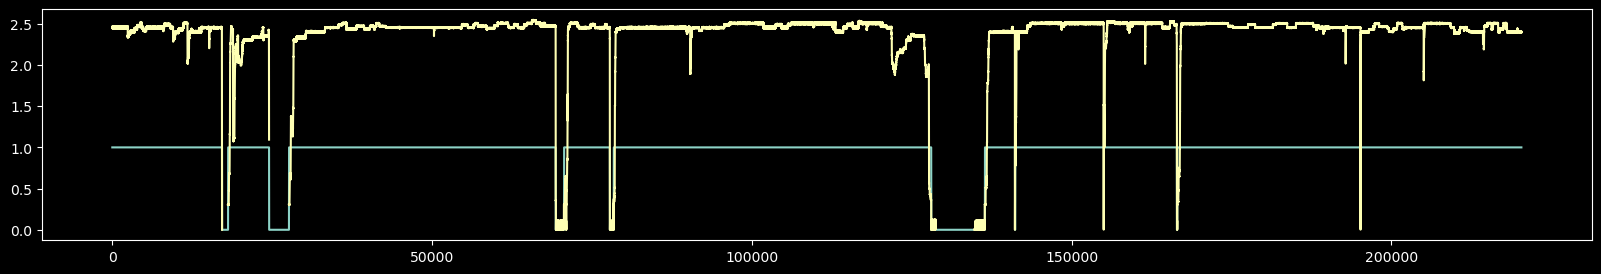

In [27]:
plt.figure(figsize=(20, 3))
df.machine_status.plot()
df.sensor_00.plot()

#### Machine Learning Model

In [41]:
X = df.drop('machine_status', axis=1)
y = df['machine_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [42]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [43]:
predictions = model.predict(X_test)

print('Accuracy score: ', accuracy_score(y_test, predictions).round(2))
print('F1 score: ', f1_score(y_test, predictions, average='weighted').round(2))

Accuracy score:  1.0
F1 score:  1.0


In [44]:
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4292
           1       1.00      1.00      1.00     61804

    accuracy                           1.00     66096
   macro avg       1.00      1.00      1.00     66096
weighted avg       1.00      1.00      1.00     66096



Text(50.722222222222214, 0.5, 'Actual')

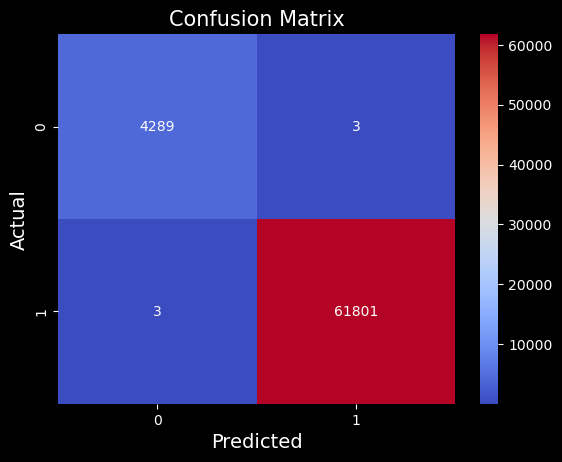

In [45]:
confusion_matrix_test = confusion_matrix(y_test, predictions)

sns.heatmap(confusion_matrix_test, 
            annot=True, 
            fmt="d", 
            cmap="coolwarm")

plt.title("Confusion Matrix",fontsize=15)
plt.xlabel("Predicted",fontsize=14)
plt.ylabel("Actual",fontsize=14)

#### Feature selection

In [51]:
# get feature importance from XGBoost
importance = model.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
# plt.bar([x for x in range(len(importance))], importance)
# plt.show()

Feature: 0, Score: 0.93109
Feature: 1, Score: 0.00069
Feature: 2, Score: 0.00568
Feature: 3, Score: 0.00366
Feature: 4, Score: 0.00426
Feature: 5, Score: 0.00425
Feature: 6, Score: 0.00358
Feature: 7, Score: 0.00305
Feature: 8, Score: 0.00020
Feature: 9, Score: 0.00011
Feature: 10, Score: 0.00233
Feature: 11, Score: 0.00133
Feature: 12, Score: 0.00100
Feature: 13, Score: 0.00707
Feature: 14, Score: 0.00059
Feature: 15, Score: 0.00186
Feature: 16, Score: 0.00022
Feature: 17, Score: 0.00020
Feature: 18, Score: 0.00018
Feature: 19, Score: 0.00027
Feature: 20, Score: 0.00026
Feature: 21, Score: 0.00254
Feature: 22, Score: 0.00094
Feature: 23, Score: 0.00035
Feature: 24, Score: 0.00793
Feature: 25, Score: 0.00035
Feature: 26, Score: 0.00294
Feature: 27, Score: 0.00036
Feature: 28, Score: 0.00066
Feature: 29, Score: 0.00062
Feature: 30, Score: 0.00106
Feature: 31, Score: 0.00028
Feature: 32, Score: 0.00091
Feature: 33, Score: 0.00049
Feature: 34, Score: 0.00059
Feature: 35, Score: 0.00136
Fe

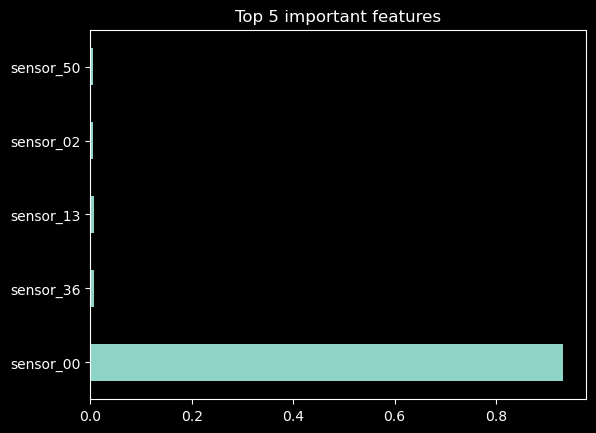

In [50]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.title("Top 5 important features")
plt.show()

In [65]:
# Remove all missing data
df1 = df.dropna(how='any', axis = 0)

X = df1.drop('machine_status', axis=1)
y = df1['machine_status']

#### Select K Best

In [35]:
from sklearn.feature_selection import SelectKBest

# ANOVA feature selection for numeric input and categorical output
from sklearn.feature_selection import f_classif

# define feature selection
fs = SelectKBest(score_func=f_classif, k=5)

# apply feature selection
X_selected = fs.fit_transform(X, y)

# get columns to keep
mask = fs.get_support()
new_features = X.columns[mask]
new_features

Index(['sensor_00', 'sensor_04', 'sensor_05', 'sensor_06', 'sensor_10'], dtype='object')

#### RFECV (Recursive Feature Elimination with Cross-Validation to select features)
Automatically chooses the number of selected features.

In [36]:
# # Recursive Feature Elimination 
# from sklearn.feature_selection import RFECV

# rfe = RFECV(model)
# rfe = rfe.fit(X, y)

# # get columns to keep
# new_features = rfe.get_feature_names_out(X.columns)
# print(new_features)
# ['sensor_00', 'sensor_02', 'sensor_13', 'sensor_36', 'sensor_38']

# # Summarize all RFE features
# for i in range(X.shape[1]):
# print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

#### Explore Number of Features

In [38]:
# from sklearn.pipeline import Pipeline
# from sklearn.feature_selection import RFE
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.model_selection import cross_val_score

# # get a list of models to evaluate
# def get_models():
#     models = dict()
#     for i in range(2, 10):
#         rfe = RFE(estimator=XGBClassifier(), n_features_to_select=i)
#         model = XGBClassifier()
#         models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
#     return models
 
# # evaluate a give model using cross-validation
# def evaluate_model(model, X, y):
#     cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#     scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
#     return scores

# # get the models to evaluate
# models = get_models()

# # evaluate the models and store results
# results, names = list(), list()
# for name, model in models.items():
#     scores = evaluate_model(model, X, y)
#     results.append(scores)
#     names.append(name)
#     print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

# # plot model performance for comparison
# plt.boxplot(results, labels=names, showmeans=True)
# plt.show()

In [66]:
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA

#create PCA model
pca = PCA(n_components = .99, svd_solver = 'full', random_state = 42 )
pca.fit(X)
print(f'Number of components after reduction: {pca.n_components_}')

Number of components after reduction: 13


In [76]:
n_comps = pca.n_components_
most_important_comps = [np.abs(pca.components_[i]).argmax() for i in range(n_comps)]

intital_features = list(X.columns)
most_important_sensors = [intital_features[most_important_comps[i]] for i in range(n_comps)]

dic = {'PC{}'.format(i+1): most_important_sensors[i] for i in range(n_comps)}
df = pd.DataFrame(sorted(dic.items()))

print("Most Important Features") 
df

Most Important Features


,0,1
0,PC1,sensor_28
1,PC10,sensor_35
2,PC11,sensor_51
3,PC12,sensor_48
4,PC13,sensor_48
5,PC2,sensor_36
6,PC3,sensor_31
7,PC4,sensor_29
8,PC5,sensor_28
9,PC6,sensor_30
